# Annotated Trajectory Example

This example shows how to annotate a trajectory (and save the annotations) using the `annotated_trajectories` package, which supplements OpenPathSampling.

First you'll need to import the two packages (after installing them, of course).

In [1]:
import openpathsampling as paths
from annotated_trajectories import AnnotatedTrajectory, Annotation, plot_annotated

Now I'm going to create some fake data:

In [2]:
from openpathsampling.tests.test_helpers import make_1d_traj
traj = make_1d_traj([-1, 1, 4, 3, 6, 11, 22, 33, 23, 101, 205, 35, 45])

In [3]:
# to get a real trajectory:
# from openpathsampling.engines.openmm.tools import ops_load_trajectory
# traj = ops_load_trajectory("name_of_file.xtc", top="topology.pdb")  # can also be a .gro

Next I'll open the file. You'll only do this once, and then add all of your annotations for each trajectory into the open file.

In [4]:
storage = paths.Storage("output.nc", "w")

## Annotating trajectories

Now we get to the core. For each trajectory, you can choose state names, and you create a list of annotations for those states. Each annotation includes the state name, the first frame in the state, and the final frame in the state (first and final, named `begin` and `end`, are included in the state). Remember that, in Python, the first frame is 0.

Once you've made your annotations, you assign them to your trajectory by putting them both into an `AnnotatedTrajectory` object.

In [5]:
annotations = [
    Annotation(state="1-digit", begin=1, end=4),
    Annotation(state="2-digit", begin=6, end=8),
    Annotation(state="3-digit", begin=10, end=10),
    Annotation(state="2-digit", begin=11, end=12)
]
a_traj = AnnotatedTrajectory(trajectory=traj, annotations=annotations)

Note that I worry more about incorrectly identifying something as in the state when it actually is not, than missing any frame that could be in the state. There's always some room for optimization here, but you should err on the side of ensuring that your labels actually identify that state. Allow false negatives; don't allow false positives.

Next, you save the trajectory to the file using the `tag` attribute of the `storage`. This will save both the trajectory and all its annotations to the file.

In the future, we hope to avoid use of the `tag` store. However, for now I recommend using something like the file name of the trajectory as the string for the tag. It must be unique.

In [6]:
storage.tag['my_file_name'] = a_traj

Repeat the steps in the last two cells for each trajectory. When you're done, you can run:

In [7]:
storage.sync()
storage.close()

## Plotting annotations

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

In [9]:
def ln_x(snapshot):
    import math
    return math.log10(abs(snapshot.xyz[0][0]))

cv = paths.CoordinateFunctionCV("log(x)", ln_x)

In [10]:
state_1 = paths.CVDefinedVolume(cv, 0.0, 1.0)
state_2 = paths.CVDefinedVolume(cv, 1.0, 2.0)
state_3 = paths.CVDefinedVolume(cv, 2.0, 3.0)

In [11]:
names_to_states = {
    '1-digit': state_1,
    '2-digit': state_2,
    '3-digit': state_3,    
}
names_to_colors = {
    '1-digit': 'b',
    '2-digit': 'c',
    '3-digit': 'r'
}

(-0.1, 2.5)

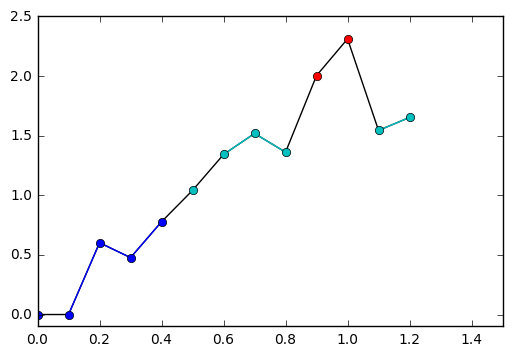

In [12]:
plot_annotated(a_traj, cv, names_to_states, names_to_colors, dt=0.1)
plt.xlim(xmax=1.5)
plt.ylim(ymin=-0.1)

## Checking for conflicts

Now I'm going to label one of my frames in a way that conflicts with my state definition. This means I'll have a false positive: the state definition says this is in the state when the annotation says it isn't (and specifically, when the annotation says it is in a different state).

Note that this still isn't a sufficient check: a more complicated test would ensure that, if the state gives a false positive where there is *no* annotation, that one of the nearest annotations (forward or backward) is of the same state. This has not been implemented yet, but might be added in the future.

In [13]:
# only difference is that I claim frame 5 (x=11) is in the 1-digit state
bad_annotations = [
    Annotation(state="1-digit", begin=1, end=5),
    Annotation(state="2-digit", begin=6, end=8),
    Annotation(state="3-digit", begin=10, end=10),
    Annotation(state="2-digit", begin=11, end=12)
]
bad_traj = AnnotatedTrajectory(traj, bad_annotations)

(-0.1, 2.5)

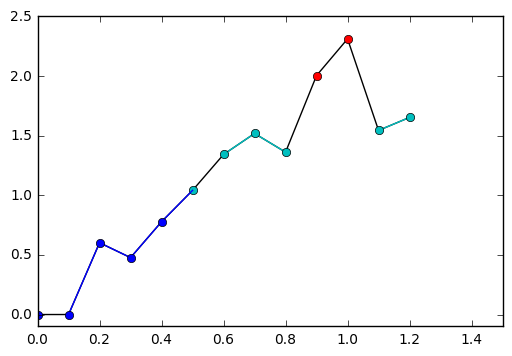

In [14]:
plot_annotated(bad_traj, cv, names_to_states, names_to_colors, dt=0.1)
plt.xlim(xmax=1.5)
plt.ylim(ymin=-0.1)

Note how the value at $t=0.5$ conflicts: the annotation (the line) says that this this is in the blue (1-digit) state, whereas the state definition (the points) says that this is in the can (2-digit) state.

In [15]:
(results, conflicts) = bad_traj.validate_states(names_to_states)

The results object will count something as a false postive if the state identifies it, but the annotation doesn't. Not all false positives are bad: if the state identified by the annotation is smaller than the state definition, then the state definition will catch some frames that the annotation left marked as not in any state.

It will count something as a false negative if the annotation identifies it, but the state doesn't. Not all false negatives are bad: this merely indicates that the state definitions may claim a frame is in no state, even though the annotation says it is in a state. In fact, we typically want this: a reasonable number of false negatives is necessary for your state to a have a decent flux in TIS.

In [16]:
print results['1-digit']

Correct: 4
False positive: 1
False negative: 1


In [17]:
print results['2-digit']

Correct: 5
False positive: 1
False negative: 0


In [18]:
print results['3-digit']

Correct: 1
False positive: 1
False negative: 0


In [19]:
print bad_traj.trajectory.index(results['1-digit'].false_negative[0])

5


While false positives and false negatives are not inherently bad, conflicts are. A frame is said to be in conflict if the state definition assigns a different state than the annotation. The `conflicts` dictionary tells which frame numbers are in conflict, organized by which state definition volume they are in.

In [20]:
print conflicts

{'2-digit': [5], '1-digit': [], '3-digit': []}


You can identify which state the annotations claim using `get_label_for_frame`:

In [21]:
bad_traj.get_label_for_frame(5)

'1-digit'